In [27]:
import numpy as np
import vip_hci
from os import mkdir
from os.path import join, sep,exists
import glob
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import stats
from scipy.ndimage.filters import median_filter
from scipy.ndimage.interpolation import shift

Perform H Band reduction

In [28]:
# Set up paths 
frameSize = 351
band = 'H'
tg_name= '2M1207'
useRefFrames = False
path_input = '/home/ubuntu/Downloads/2M1207_bands/Hband/'
path_output = path_input + 'out/'
sep='/'
print(path_input)

path_flats = path_input+'flats'+sep
path_flats_darks = path_input+'flats/darks'+sep
path_sci = path_input+'sci'+sep
path_darks = path_input+'darks'+sep

/home/ubuntu/Downloads/2M1207_bands/Hband/


In [29]:
# File list
filelist_flats = glob.glob(path_flats+'*.fits')
filelist_flats_darks = glob.glob(path_flats_darks+'*.fits')
filelist_sci = sorted(glob.glob(path_sci+'*.fits'))
filelist_darks = glob.glob(path_darks+'*.fits')

print((filelist_sci))

['/home/ubuntu/Downloads/2M1207_bands/Hband/sci/NACO.2004-04-27T03_54_41.920.fits', '/home/ubuntu/Downloads/2M1207_bands/Hband/sci/NACO.2004-04-27T03_56_08.901.fits', '/home/ubuntu/Downloads/2M1207_bands/Hband/sci/NACO.2004-04-27T03_57_35.981.fits', '/home/ubuntu/Downloads/2M1207_bands/Hband/sci/NACO.2004-04-27T03_59_03.178.fits', '/home/ubuntu/Downloads/2M1207_bands/Hband/sci/NACO.2004-04-27T04_00_51.350.fits', '/home/ubuntu/Downloads/2M1207_bands/Hband/sci/NACO.2004-04-27T04_02_18.216.fits', '/home/ubuntu/Downloads/2M1207_bands/Hband/sci/NACO.2004-04-27T04_03_44.710.fits', '/home/ubuntu/Downloads/2M1207_bands/Hband/sci/NACO.2004-04-27T04_05_11.355.fits']


# H BAND RAW IMAGE

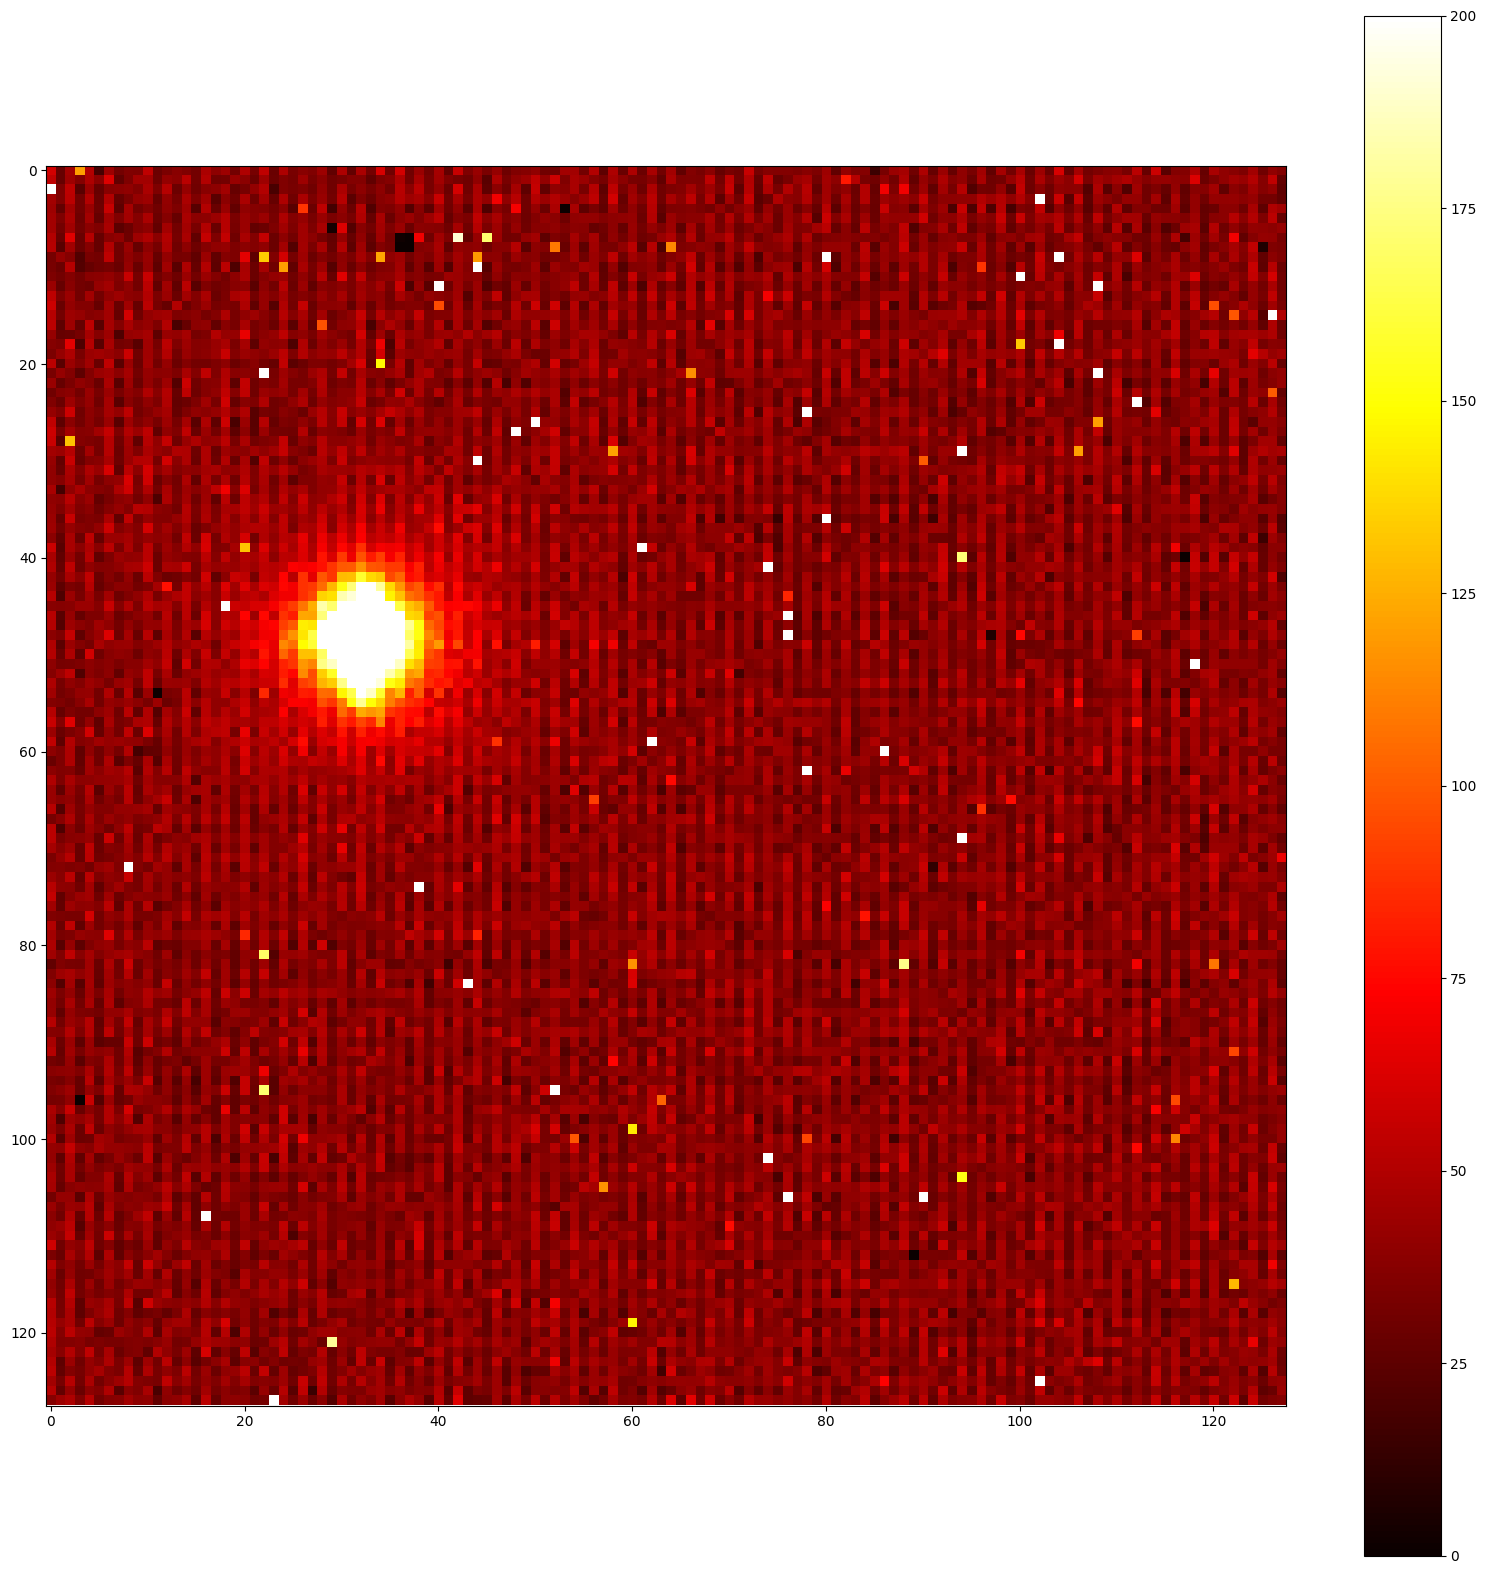

In [30]:
raw_sci = fits.open(filelist_sci[0])[0].data
crop = 128
dimx = raw_sci.shape[0]
dimy = raw_sci.shape[1]
x1 = int((dimx - crop)/2)
x2 = int(x1 + crop)
y1 = int((dimy - crop)/2)
y2 = int(y1 + crop)
raw_sci = shift(raw_sci,[-100,-100])
raw_cropped = raw_sci[x1:x2,y1:y2]
raw_cropped.shape
plt.figure(figsize=(20,20))
plt.imshow(raw_cropped,vmin=0,vmax=200,cmap='hot')
plt.colorbar()
plt.show();

The above pixel values are simply what were measured on the CCD when attempting to observe the exoplanet 2M1207, with no editing or corrections yet. 

We wrote a function to crop a given frame to crop the darks, flats, and biases as well as to make sure they are cropped the same way as the raw science frame.  

In [31]:
def crop(image, crop = 128):
    dimx, dimy = image.shape[0], image.shape[1]
    x1, y1 = int((dimx - crop)/2), int((dimy - crop)/2) 
    x2, y2 = int(x1 + crop), int(y1 + crop)
    image = shift(image, [-100,-100])
    return image[x1:x2,y1:y2]

# H BAND MASTER FLAT

The function get_flat retrieves all of the flat exposures for a given band. The options are one of the following strings: "Hband", "Jband", "Kband", or "Lband".



In [16]:
def get_flats(band):
    flat_paths = filelist_flats
    return [fits.open(flat_paths[file_num])[0].data for file_num
               in range(len(flat_paths))]

https://docs.astropy.org/en/stable/api/astropy.stats.mad_std.html 

mad_std is the median absolute deviation (1.4826 times larger than the standard deviation for a normal distribution) and is 
\begin{align}
\text{MAD} = \text{median}(|X_i - \text{median}(X)|)
\end{align}

https://photutils.readthedocs.io/en/stable/detection.html

In [26]:
from photutils import DAOStarFinder
from astropy.stats import mad_std
hband_flats = get_flats("Hband")
median_of_hband_flats = np.array( [
        np.median( [hband_flats[exposure][pixel] 
        for exposure in range(len(hband_flats))] )
    for pixel in range(len(hband_flats[0]))] )
final_image_cropped = median_of_hband_flats
bkg_sigma = mad_std(final_image_cropped)
filter_fwhm = 206265*1630.0*1.0e-9/8.2 / 0.012
daofind = DAOStarFinder(fwhm = filter_fwhm, threshold = 3.0*bkg_sigma)
sources = daofind(final_image_cropped)
for col in sources.colnames:
    sources[col].info.format = '%.8g'
print(sources)

from photutils import aperture_photometry, CircularAperture
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(positions, r=filter_fwhm)
phot_table = aperture_photometry(final_image_cropped, apertures)
for col in phot_table.colnames:
    phot_table[col].info.format = '%.8g'
print(phot_table)

plt.figure(figsize = [20,20])
plt.imshow(final_image_cropped,vmin=0,vmax=20,cmap='hot')
plt.colorbar()
apertures.plot(color = 'cyan', lw = 5, alpha = 0.75)

RuntimeError: filter weights array has incorrect shape.

In [27]:
print(bkg_sigma)
FluxRatio = phot_table[1][3]/phot_table[2][3]
print("Planet Mag = ", -2.5*np.log10(FluxRatio) + 12.388)

1.2349174286296776
Planet Mag =  nan


<ipython-input-27-dc86989db42c>:3: RuntimeWarning: invalid value encountered in log10
  print("Planet Mag = ", -2.5*np.log10(FluxRatio) + 12.388)
